# Experiment Results Analysis

This notebook loads experiment results and generates plots comparing different data loading strategies across the four classification tasks:
- Cell line classification
- Drug classification
- MOA (broad) classification
- MOA (fine) classification

In [1]:
# Imports and setup
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add parent directory to path
notebook_dir = Path().absolute()
project_root = notebook_dir.parent.parent
sys.path.insert(0, str(project_root))

# Import analysis utilities
from training_experiments.analysis import (
    load_experiment_results,
    load_multiple_run_results,  # For loading multiple runs from directories
    extract_metrics,
    create_comparison_dataframe,
    create_comparison_dataframe_from_multiple_runs,  # For auto error bars from directories
    create_comparison_dataframe_from_manual_runs,  # For manual multi-run data entry
    get_time_comparison,
    print_results_table,
    STRATEGY_DISPLAY_NAMES,
    TASK_DISPLAY_NAMES,
    DEFAULT_YLIM,
)
from training_experiments.analysis.plotting import (
    plot_comparison,
    plot_training_curves,
    plot_time_comparison,
)

# Set default plot style
sns.set(style="whitegrid", context="talk")
plt.rcParams['figure.dpi'] = 100

print("✓ Setup complete")

✓ Setup complete


## Configuration

Set the path to your experiment results directory:

In [2]:
# Path to experiment results
# Update this to point to your results directory
RESULTS_DIR = notebook_dir.parent / "results" / "main"

# Alternative: absolute path
# RESULTS_DIR = Path("/path/to/training_experiments/results")

print(f"Results directory: {RESULTS_DIR}")
print(f"Exists: {RESULTS_DIR.exists()}")

if RESULTS_DIR.exists():
    print("\nContents:")
    for p in sorted(RESULTS_DIR.iterdir()):
        print(f"  {p.name}")

Results directory: /home/kidara/raid/volume/scDataset/training_experiments/results/main
Exists: True

Contents:
  block_shuffling_64bs_0.001lr
  comparison_pivot.csv
  comparison_plot.pdf
  comparison_plot.png
  comparison_results.csv
  random_sampling_64bs_0.001lr
  streaming_64bs_0.001lr
  streaming_buffer_64bs_0.001lr
  time_comparison.pdf
  time_comparison.png
  training_curves.pdf
  training_curves.png


## Loading Multiple Runs (for Error Bars)

If you have results from multiple experiment runs (e.g., with different random seeds), you can load them all and automatically compute error bars (standard deviation across runs).

**Directory structure for multiple runs:**
```
results/
├── run_seed42/
│   ├── streaming_64bs_0.001lr/
│   ├── block_shuffling_64bs_0.001lr/
│   └── ...
├── run_seed43/
│   ├── streaming_64bs_0.001lr/
│   └── ...
└── run_seed44/
    ├── streaming_64bs_0.001lr/
    └── ...
```

In [3]:
# Example: Loading multiple runs for error bars
# Uncomment and modify the paths to match your directory structure

# Option 1: Multiple run directories (different seeds)
# RUN_DIRS = [
#     notebook_dir.parent / "results" / "run_seed42",
#     notebook_dir.parent / "results" / "run_seed43", 
#     notebook_dir.parent / "results" / "run_seed44",
# ]

# Option 2: Auto-discover run directories matching a pattern
# RESULTS_BASE = notebook_dir.parent / "results"
# RUN_DIRS = sorted(RESULTS_BASE.glob("run_seed*"))

# Load all runs
# results_list = load_multiple_run_results([str(d) for d in RUN_DIRS])
# print(f"Loaded {len(results_list)} runs")

# Create DataFrame with automatic error bars (std across runs)
# df_with_errors = create_comparison_dataframe_from_multiple_runs(results_list, metric_name='f1_macro')
# display(df_with_errors)

# The 'Error' column now contains the standard deviation across runs
# plot_comparison(df_with_errors) will automatically show error bars!

USE_MULTIPLE_RUNS = False  # Set to True when you have multiple run directories

## Load Results

Load all experiment results from the results directory:

In [4]:
# Load experiment results
results = load_experiment_results(RESULTS_DIR)

print(f"Loaded results for {len(results)} strategies:")
for strategy in results:
    status = results[strategy].get('status', 'unknown')
    print(f"  - {strategy}: {status}")

Loaded results for 4 strategies:
  - streaming: success
  - streaming_buffer: success
  - block_shuffling: success
  - random_sampling: success


In [5]:
# Print results summary table
if results:
    print_results_table(results, metric_name='f1_macro')
else:
    print("No results to display. Run experiments first.")


Strategy                  |  Cell Line |       Drug |  MOA Broad |   MOA Fine
--------------------------------------------------------------------------------
Streaming                 |     0.9161 |     0.0013 |     0.1854 |     0.0417
Streaming (buffer)        |     0.9169 |     0.0000 |     0.1994 |     0.0390
Block size = 16 Fetch factor = 256 |     0.9207 |     0.0275 |     0.2928 |     0.0863
Random Sampling           |     0.9198 |     0.0311 |     0.2728 |     0.0887



## Manual Results Entry (Optional)

You can manually enter results in two ways:
1. **Single run** - Enter one set of results (no error bars)
2. **Multiple runs** - Enter results from multiple runs and automatically compute error bars

Both methods are shown below. Set the appropriate flag to use your preferred method.

In [6]:
# =============================================================================
# MANUAL MULTI-RUN DATA ENTRY (for automatic error bars)
# =============================================================================
# Enter results from multiple experiment runs below.
# Each run is a dictionary mapping strategy keys to their F1 scores per task.
# Error bars (std deviation) will be computed automatically!

manual_runs = [
    # Run 1
    {
        'streaming': {
            'cell_line': 0.934987,
            'drug': 0.002345,
            'moa_broad': 0.203723,
            'moa_fine': 0.054910,
        },
        'streaming_buffer': {
            'cell_line': 0.934966,
            'drug': 0.002066,
            'moa_broad': 0.194256,
            'moa_fine': 0.054237,
        },
        'block_shuffling': {
            'cell_line': 0.937310,
            'drug': 0.029921,
            'moa_broad': 0.270052,
            'moa_fine': 0.102747,
        },
        'random_sampling': {
            'cell_line': 0.937533,
            'drug': 0.029771,
            'moa_broad': 0.267968,
            'moa_fine': 0.101868,
        },
    },
    # Run 2
    {
        'streaming': {
            'cell_line': 0.934980,
            'drug': 0.002302,
            'moa_broad': 0.203693,
            'moa_fine': 0.054779,
        },
        'streaming_buffer': {
            'cell_line': 0.935011,
            'drug': 0.002064,
            'moa_broad': 0.194179,
            'moa_fine': 0.054187,
        },
        'block_shuffling': {
            'cell_line': 0.937296,
            'drug': 0.030829,
            'moa_broad': 0.269570,
            'moa_fine': 0.103001,
        },
        'random_sampling': {
            'cell_line': 0.937409,
            'drug': 0.030055,
            'moa_broad': 0.268011,
            'moa_fine': 0.104067,
        },
    },
]


# Custom display names for manual data
# Must match the standard names used in other plots
manual_method_names = {
    'streaming': 'Streaming',
    'streaming_buffer': 'Streaming (buffer)',
    'block_shuffling': 'Block size = 16\nFetch factor = 256',
    'random_sampling': 'Random Sampling',
}

# =============================================================================
# SINGLE RUN MANUAL DATA (alternative, no error bars)
# =============================================================================
# Uncomment to use single-run format instead:

# manual_data = [
#     # (Task, Method, Macro F1-score, Error)
#     ('Cell line', 'Streaming', 0.935, 0.0),
#     ('Cell line', 'Streaming (buffer)', 0.936, 0.0),
#     ('Cell line', 'Block size = 16\nFetch factor = 256', 0.937, 0.0),
#     ('Cell line', 'Random Sampling', 0.930, 0.0),
#     # ... add more rows for Drug, MOA (broad), MOA (fine)
# ]
# manual_df = pd.DataFrame(manual_data, columns=['Task', 'Method', 'Macro F1-score', 'Error'])

# =============================================================================
# CONFIGURATION FLAGS
# =============================================================================
USE_MANUAL_DATA = True  # Set to True to use manual data entry
USE_MANUAL_MULTI_RUN = True  # If True, uses manual_runs with auto error bars

## Create Comparison DataFrame

Prepare data for plotting:

In [7]:
# Priority order for data sources:
# 1. Manual multi-run data (USE_MANUAL_DATA=True, USE_MANUAL_MULTI_RUN=True)
# 2. Manual single-run data (USE_MANUAL_DATA=True, USE_MANUAL_MULTI_RUN=False)
# 3. Multiple run directories (USE_MULTIPLE_RUNS=True)
# 4. Single results directory (default)

if USE_MANUAL_DATA and USE_MANUAL_MULTI_RUN:
    # Create DataFrame from manually entered multi-run data with auto error bars
    df = create_comparison_dataframe_from_manual_runs(
        manual_runs,
        method_names=manual_method_names
    )
    print(f"Created comparison DataFrame from {len(manual_runs)} manual runs")
    print(f"Expected: {len(manual_runs[0])} methods × 4 tasks = {len(manual_runs[0]) * 4} rows")
    print("Note: 'Error' column contains std deviation across runs")
    display(df)

elif USE_MANUAL_DATA:
    # Use single-run manual data (manual_df)
    df = manual_df
    print(f"Using single-run manual data with {len(df)} rows (no error bars)")
    display(df)

elif USE_MULTIPLE_RUNS:
    # Load from multiple run directories and compute error bars automatically
    RUN_DIRS = sorted((notebook_dir.parent / "results").glob("run_*"))
    results_list = load_multiple_run_results([str(d) for d in RUN_DIRS])
    print(f"Loaded {len(results_list)} runs from {len(RUN_DIRS)} directories")
    
    # Create DataFrame with automatic error bars (std across runs)
    df = create_comparison_dataframe_from_multiple_runs(results_list, metric_name='f1_macro')
    print(f"Created comparison DataFrame with {len(df)} rows")
    print("Note: 'Error' column contains std deviation across runs")
    display(df)
    
elif results:
    # Create DataFrame from single run (no error bars)
    df = create_comparison_dataframe(results, metric_name='f1_macro')
    print(f"Created comparison DataFrame with {len(df)} rows (single run, no error bars)")
    display(df)
    
else:
    print("No data available. Please either:")
    print("  1. Set USE_MANUAL_DATA=True and enter data in manual_runs or manual_df")
    print("  2. Set USE_MULTIPLE_RUNS=True and configure RUN_DIRS")
    print("  3. Run experiments to generate results in RESULTS_DIR")

Created comparison DataFrame from 2 manual runs
Expected: 4 methods × 4 tasks = 16 rows
Note: 'Error' column contains std deviation across runs


,Task,Method,Macro F1-score,Error,N_runs
0,Cell line,Streaming,0.934983,0.000005,2
1,Drug,Streaming,0.002324,0.000030,2
2,MOA (broad),Streaming,0.203708,0.000021,2
3,MOA (fine),Streaming,0.054845,0.000093,2
4,Cell line,Streaming (buffer),0.934989,0.000032,2
5,Drug,Streaming (buffer),0.002065,0.000001,2
6,MOA (broad),Streaming (buffer),0.194217,0.000054,2
7,MOA (fine),Streaming (buffer),0.054212,0.000035,2
8,Cell line,Block size = 16\nFetch factor = 256,0.937303,0.000010,2
9,Drug,Block size = 16\nFetch factor = 256,0.030375,0.000642,2


## Main Comparison Plot

Generate the 2x2 comparison plot for all classification tasks:


Figure saved to: /home/kidara/raid/volume/scDataset/training_experiments/results/main/comparison_plot.png
Figure saved to: /home/kidara/raid/volume/scDataset/training_experiments/results/main/comparison_plot.pdf


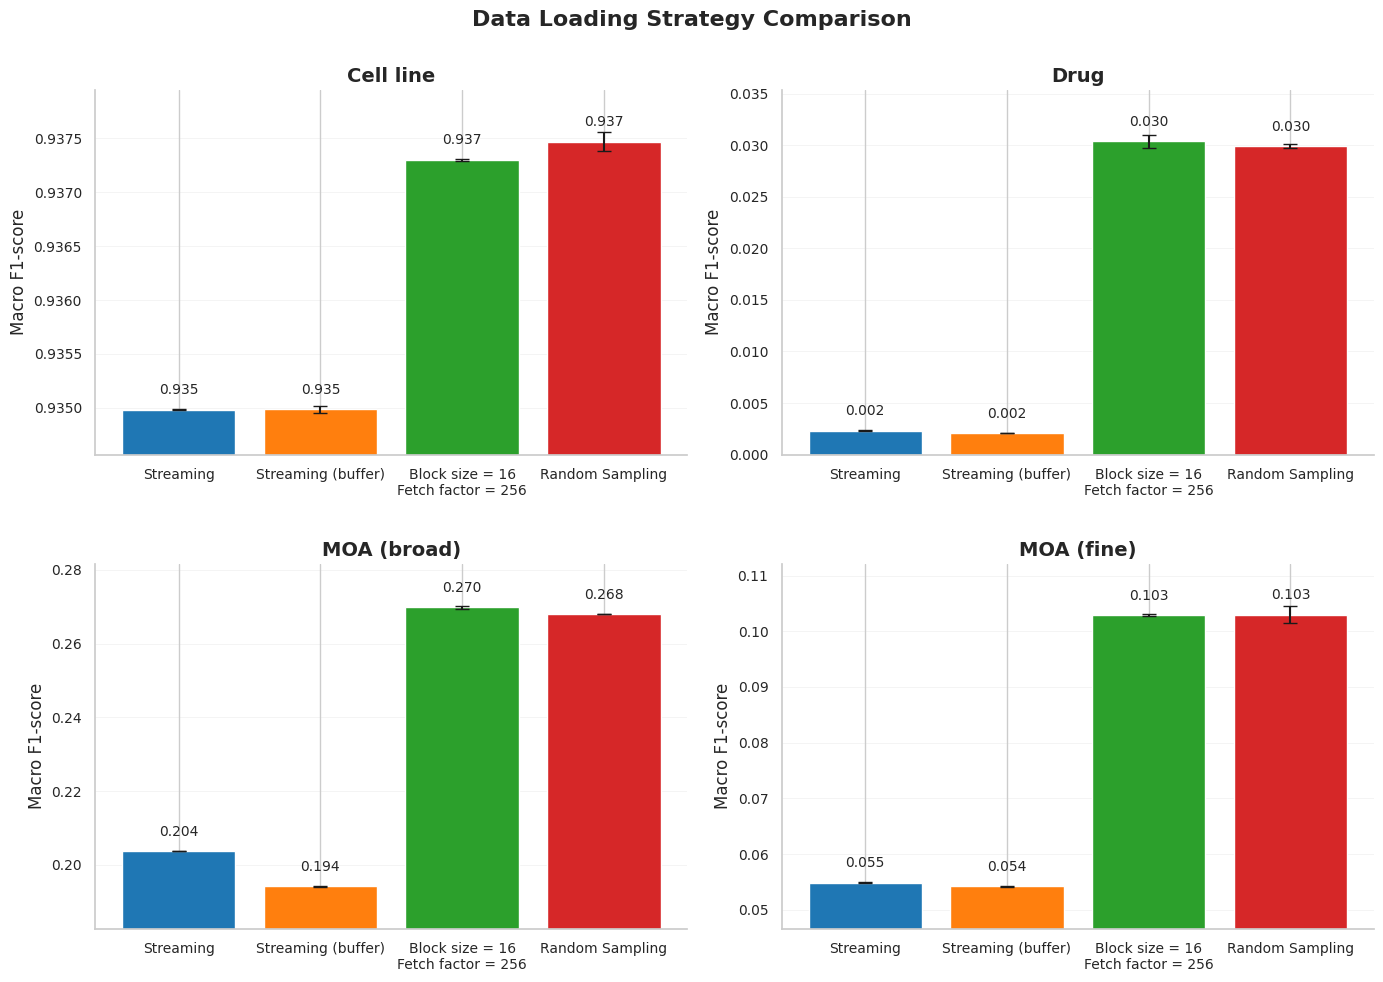

In [8]:
# Define custom y-axis limits for each task
# Adjust these based on your results
ylim_dict = {
    'Cell line': (0.8, 0.95),
    'Drug': (0.0, 0.035),
    'MOA (broad)': (0.0, 0.35),
    'MOA (fine)': (0.0, 0.09),
}

# Generate the comparison plot
if 'df' in dir() and len(df) > 0:
    fig, axes = plot_comparison(
        df,
        #ylim_dict=ylim_dict,
        figsize=(14, 10),
        title="Data Loading Strategy Comparison"
    )
    
    # Save figure (both PNG and PDF)
    output_path_png = RESULTS_DIR / "comparison_plot.png"
    output_path_pdf = RESULTS_DIR / "comparison_plot.pdf"
    fig.savefig(output_path_png, dpi=150, bbox_inches='tight')
    fig.savefig(output_path_pdf, bbox_inches='tight')
    print(f"\nFigure saved to: {output_path_png}")
    print(f"Figure saved to: {output_path_pdf}")
    
    plt.show()
else:
    print("No data available for plotting")

## Training Time Comparison

Figure saved to: /home/kidara/raid/volume/scDataset/training_experiments/results/main/time_comparison.png
Figure saved to: /home/kidara/raid/volume/scDataset/training_experiments/results/main/time_comparison.pdf


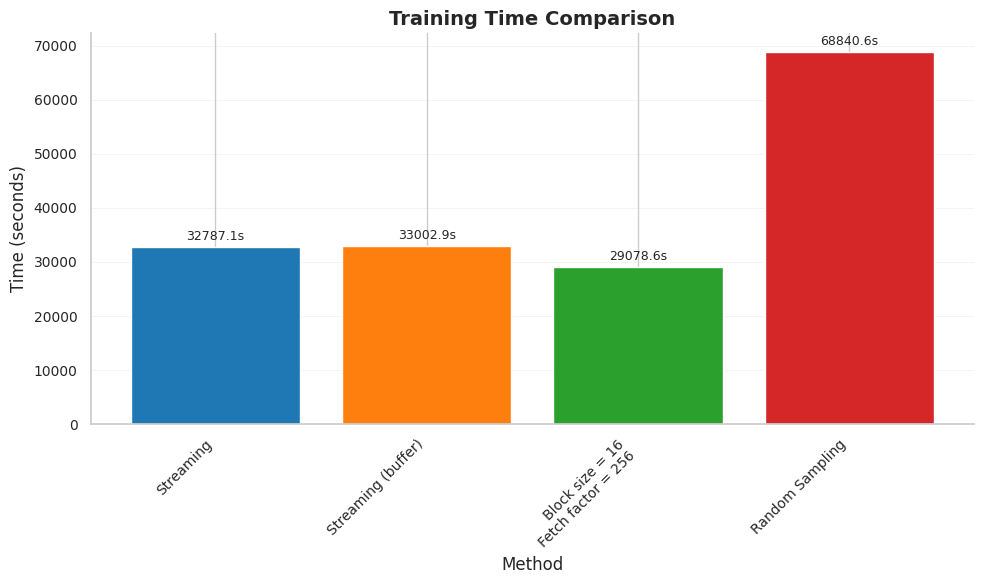

In [9]:
# Plot training time comparison
if results:
    time_df = get_time_comparison(results)
    
    if len(time_df) > 0:
        fig, ax = plot_time_comparison(time_df)
        
        # Save figure (both PNG and PDF)
        output_path_png = RESULTS_DIR / "time_comparison.png"
        output_path_pdf = RESULTS_DIR / "time_comparison.pdf"
        fig.savefig(output_path_png, dpi=150, bbox_inches='tight')
        fig.savefig(output_path_pdf, bbox_inches='tight')
        print(f"Figure saved to: {output_path_png}")
        print(f"Figure saved to: {output_path_pdf}")
        
        plt.show()
    else:
        print("No timing data available")
else:
    print("No results loaded")

## Training Curves

/tmp/ipykernel_671044/1392450033.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best', fontsize=8)


Figure saved to: /home/kidara/raid/volume/scDataset/training_experiments/results/main/training_curves.png
Figure saved to: /home/kidara/raid/volume/scDataset/training_experiments/results/main/training_curves.pdf


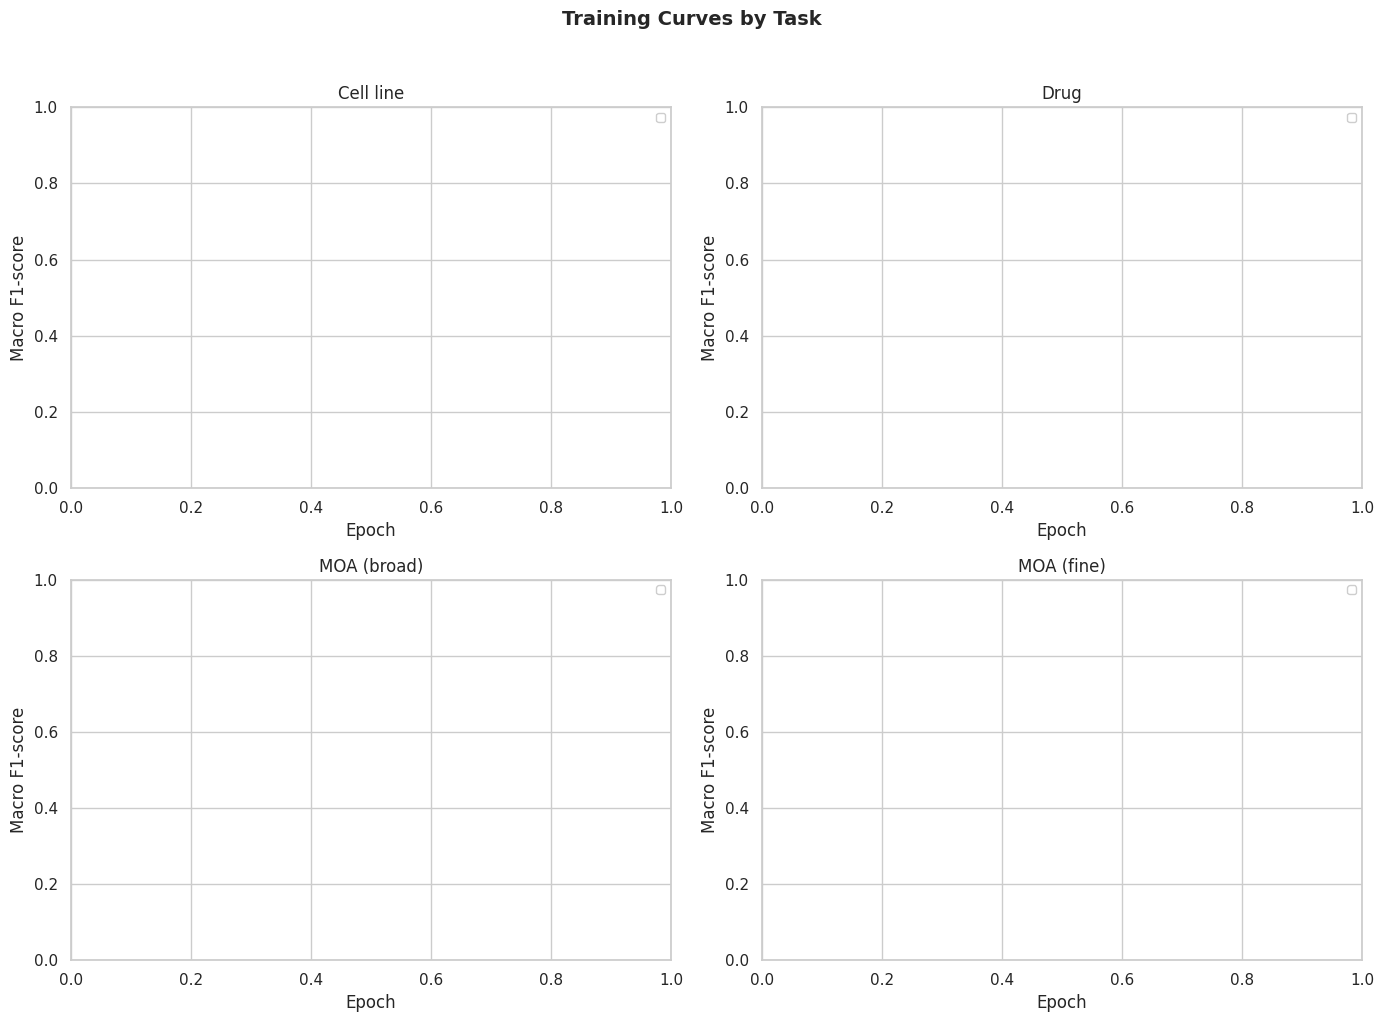

In [10]:
# Plot training curves for each task
if results:
    tasks = ['cell_line', 'drug', 'moa_broad', 'moa_fine']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, task in enumerate(tasks):
        ax = axes[idx]
        
        for strategy, result in results.items():
            if result.get('status') != 'success':
                continue
            
            history = result.get('history', {})
            metric_key = f'val_{task}_f1_macro'
            
            if metric_key in history:
                values = history[metric_key]
                epochs = list(range(1, len(values) + 1))
                label = STRATEGY_DISPLAY_NAMES.get(strategy, strategy).replace('\n', ' ')
                ax.plot(epochs, values, label=label, marker='o', markersize=4)
        
        task_name = TASK_DISPLAY_NAMES.get(task, task)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Macro F1-score')
        ax.set_title(task_name)
        ax.legend(loc='best', fontsize=8)
    
    plt.suptitle('Training Curves by Task', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Save figure (both PNG and PDF)
    output_path_png = RESULTS_DIR / "training_curves.png"
    output_path_pdf = RESULTS_DIR / "training_curves.pdf"
    fig.savefig(output_path_png, dpi=150, bbox_inches='tight')
    fig.savefig(output_path_pdf, bbox_inches='tight')
    print(f"Figure saved to: {output_path_png}")
    print(f"Figure saved to: {output_path_pdf}")
    
    plt.show()
else:
    print("No results loaded")

## Export Results to CSV

In [11]:
# Export comparison data to CSV
if 'df' in dir() and len(df) > 0:
    csv_path = RESULTS_DIR / "comparison_results.csv"
    df.to_csv(csv_path, index=False)
    print(f"Results exported to: {csv_path}")
    
    # Also create a pivot table
    pivot_df = df.pivot(index='Method', columns='Task', values='Macro F1-score')
    pivot_path = RESULTS_DIR / "comparison_pivot.csv"
    pivot_df.to_csv(pivot_path)
    print(f"Pivot table exported to: {pivot_path}")
    
    print("\nPivot Table:")
    display(pivot_df)

Results exported to: /home/kidara/raid/volume/scDataset/training_experiments/results/main/comparison_results.csv
Pivot table exported to: /home/kidara/raid/volume/scDataset/training_experiments/results/main/comparison_pivot.csv

Pivot Table:


Task,Cell line,Drug,MOA (broad),MOA (fine)
Method,,,,
Block size = 16\nFetch factor = 256,0.937303,0.030375,0.269811,0.102874
Random Sampling,0.937471,0.029913,0.267989,0.102968
Streaming,0.934983,0.002324,0.203708,0.054845
Streaming (buffer),0.934989,0.002065,0.194217,0.054212


## Summary Statistics

In [12]:
# Print summary statistics
if 'df' in dir() and len(df) > 0:
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    
    # Best method per task
    print("\nBest method per task:")
    for task in df['Task'].unique():
        task_data = df[df['Task'] == task]
        best_idx = task_data['Macro F1-score'].idxmax()
        best_row = df.loc[best_idx]
        print(f"  {task}: {best_row['Method'].replace(chr(10), ' ')} (F1 = {best_row['Macro F1-score']:.4f})")
    
    # Overall method comparison
    print("\nMean performance across all tasks:")
    mean_by_method = df.groupby('Method')['Macro F1-score'].mean().sort_values(ascending=False)
    for method, score in mean_by_method.items():
        print(f"  {method.replace(chr(10), ' ')}: {score:.4f}")
    
    print("\n" + "="*60)


SUMMARY STATISTICS

Best method per task:
  Cell line: Random Sampling (F1 = 0.9375)
  Drug: Block size = 16 Fetch factor = 256 (F1 = 0.0304)
  MOA (broad): Block size = 16 Fetch factor = 256 (F1 = 0.2698)
  MOA (fine): Random Sampling (F1 = 0.1030)

Mean performance across all tasks:
  Block size = 16 Fetch factor = 256: 0.3351
  Random Sampling: 0.3346
  Streaming: 0.2990
  Streaming (buffer): 0.2964

